<a href="https://colab.research.google.com/github/arunmalik1/PlantLeaf_Classification/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is binary classification project using plant images. The idea is to be able to identify diseased vs healthy plants. There are 11 different plants and the entire dataet is divded into 22 categories. 

The dataset is from Kaggle: 
This is a collection of about 4503 images of which contains 2278 images of healthy leaf and 2225 images of the diseased leaf. Twelve plants named as Mango, Arjun, Alstonia Scholaris, Guava, Bael, Jamun, Jatropha, Pongamia Pinnata, Basil, Pomegranate, Lemon, and Chinar have been selected. Images are split between training, test, validating and prediction datasets for model training and testing purposes.



#Import Packages

In [ ]:
#install and upgrade packages 

#need pydicom for images
!pip install pydicom --quiet


#installing keras tuner 
!pip install keras-tuner --quiet
!pip install visualkeras --quiet
!pip install -q -U keras-tuner --quiet
!pip install git+https://github.com/keras-team/keras-preprocessing.git --quiet
!pip install --upgrade transformers --quiet
!pip install --upgrade datasets --quiet
!pip install -Uqq fastbook --quiet


In [15]:
#import packages 
import pandas as pd
import numpy as np
import scipy
from fastbook import *
import cv2


#import plot 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
%matplotlib inline
from PIL import Image, ImageFont
import PIL.Image
import seaborn as sns
import plotly.express as px

#create reports
from tabulate import tabulate
import os
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

#import keras and tenserflow and pydicom
import keras
import pydicom
import visualkeras
import keras_tuner as kt
from keras import layers
from kerastuner import RandomSearch
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import learning_rate_schedule
from kerastuner.engine.hyperparameters import HyperParameters


#import tenserflow functions
import tensorflow as tf
from tensorflow.keras import layers
from collections import defaultdict
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

In [ ]:
#Used this code to connect Google Drive and Colabs

#from google.colab import drive
#drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


#Import Data

In [3]:
#load the train set
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/train',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (256,256),
    batch_size = 32,
    )

Found 4274 files belonging to 22 classes.


In [4]:
#load the test set
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/test',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (256,256)
    )

Found 110 files belonging to 22 classes.


In [5]:
#load the validation set
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/valid',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (256,256)
    )

Found 110 files belonging to 22 classes.


In [ ]:
#take a look at some of the images in the train set.
class_names = train_ds.class_names

### To visualize the images
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(32):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Plotting the images
plt.tight_layout(pad=1)
plt.show()

#Create a base CNN Model

In [ ]:
base_model1 = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
base_model1.add(Conv2D(filters=32,
                        kernel_size=(3, 3), strides = (2,2),
                        activation='relu',
                        input_shape=(256, 256, 3)))

#rescale the images 
tf.keras.layers.Rescaling(1./255)
# max pool in 2x2 window

# define 3x3 filter window sizes.
base_model1.add(MaxPooling2D(pool_size=(4, 4)))
base_model1.add(Conv2D(64, (3, 3), activation='relu'))

base_model1.add(MaxPooling2D((2, 2)))
base_model1.add(Conv2D(128, (3, 3), activation='relu'))

base_model1.add(MaxPooling2D((2, 2)))
base_model1.add(Conv2D(256, (3, 3), activation='relu'))

# transition to dense fully-connected part of network
base_model1.add(Flatten())
base_model1.add(Dense(64, activation='relu'))
base_model1.add(Dense(22, activation='softmax'))

In [ ]:
base_model1.compile(optimizer='Adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
history_cnn = base_model1.fit(train_ds, epochs= 20, validation_data= validation_ds)

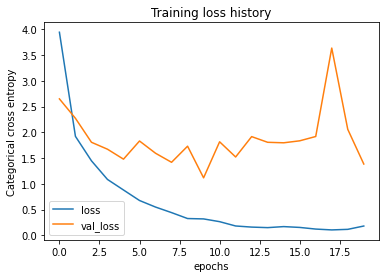

In [ ]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

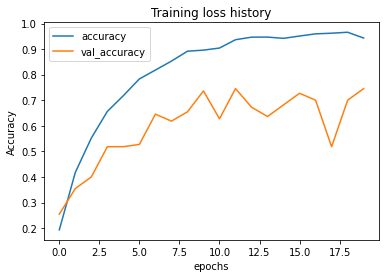

In [ ]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [ ]:
base_model1.save('Base_model1.h5')

#Building in a simpler base model because of over fitting 

In [ ]:
base_model2 = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
base_model2.add(Conv2D(filters=32,
                        kernel_size=(3, 3), strides = (2,2),
                        activation='relu',
                        input_shape=(256, 256, 3)))

#rescale the images 
tf.keras.layers.Rescaling(1./255)

# define 3x3 filter window sizes. Create 32 filters.
base_model2.add(MaxPooling2D((2, 2)))
base_model2.add(Conv2D(32, (3, 3), activation='relu'))

base_model2.add(MaxPooling2D((2, 2)))
base_model2.add(Conv2D(32, (3, 3), activation='relu'))

# transition to dense fully-connected part of network
base_model2.add(Flatten())
base_model2.add(Dense(32, activation='relu'))
base_model2.add(Dense(22, activation='softmax'))

In [ ]:
base_model2.compile(optimizer='Adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
history_cnn = base_model2.fit(train_ds, epochs= 20, validation_data= validation_ds)

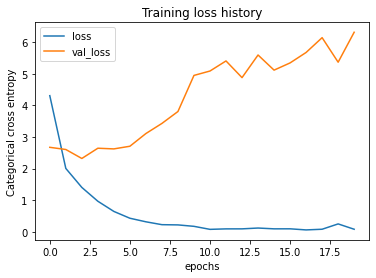

In [ ]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

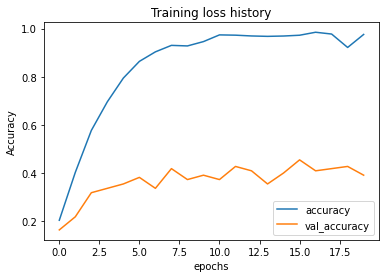

In [ ]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [ ]:
base_model2.save('BaseSimple.h5')

#Adding more layers to base model for higher accuracy. 
#Using regularizer and dropout techniques to address overfitting.

L1 (Lasso Regression)

In [ ]:
reg = L1(1e-5)

In [ ]:
L1_model = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
L1_model.add(Conv2D(filters=32,
                        kernel_size=(3, 3), strides = (3,3),
                        activation='relu',
                        input_shape=(256, 256, 3)))

#rescale the images 
tf.keras.layers.Rescaling(1./255)
# max pool in 2x2 window
L1_model.add(BatchNormalization())
L1_model.add(MaxPooling2D(pool_size=(4, 4)))
L1_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))

L1_model.add(BatchNormalization())
L1_model.add(MaxPooling2D((2, 2)))
L1_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))

L1_model.add(BatchNormalization())
L1_model.add(MaxPooling2D((2, 2)))
L1_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))

# transition to dense fully-connected part of network
L1_model.add(Flatten())
L1_model.add(Dense(64, activation='relu'))

#using dropout to create a more robust model
L1_model.add(Dropout(0.5)) 
L1_model.add(Dense(22, activation='softmax'))

In [ ]:
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-05)
L1_model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
history_cnn = L1_model.fit(train_ds, epochs= 50, validation_data= validation_ds)

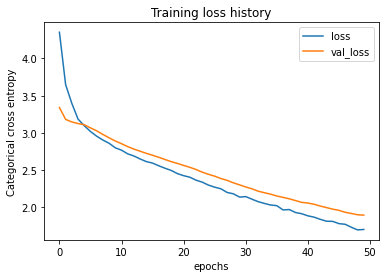

In [ ]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

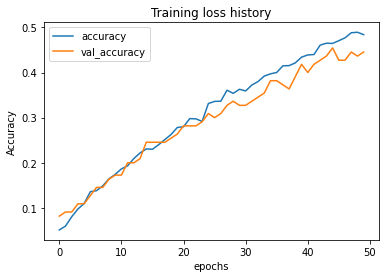

In [ ]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [ ]:
L1_model.save('L1Model.h5')

#Add data augmentation which will create more images and help with accuracy.

L1 (Lasso Regression) with Data Augmentation and Dropout.

In [7]:
#add reguarlizer to reduce overfitting 
reg = L1(3e-5)

In [8]:
#augmenting data to help train the model 
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

In [9]:
L1_model2 = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
L1_model2.add(Conv2D(filters=32, kernel_size=(3, 3), strides = (2,2),
                     activation='relu', input_shape=(256, 256, 3),
                     kernel_regularizer = reg))

#rescale the images 
tf.keras.layers.Rescaling(1./255)

# max pool in 2x2 window
#using data augmentation 
L1_model2.add(BatchNormalization())
L1_model2.add(MaxPooling2D(pool_size=(4, 4)))
data_augmentation
L1_model2.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))

L1_model2.add(BatchNormalization())
L1_model2.add(MaxPooling2D((2, 2)))
data_augmentation
L1_model2.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))

L1_model2.add(BatchNormalization())
L1_model2.add(MaxPooling2D((2, 2)))
data_augmentation
L1_model2.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))

# transition to dense fully-connected part of network
L1_model2.add(Flatten())
L1_model2.add(Dense(64, activation='relu'))

#adding dropout to help with overfitting
L1_model2.add(Dropout(0.6)) 
L1_model2.add(Dense(22, activation='softmax'))

In [10]:
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-05)
L1_model2.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['accuracy'])

In [11]:
history_cnn = L1_model2.fit(train_ds, epochs= 50, validation_data= validation_ds)

Epoch 1/50
134/134 [==============================] - 154s 1s/step - loss: 3.5636 - accuracy: 0.0681 - val_loss: 3.1208 - val_accuracy: 0.0727
Epoch 2/50
134/134 [==============================] - 47s 333ms/step - loss: 3.0364 - accuracy: 0.1259 - val_loss: 3.0485 - val_accuracy: 0.0909
Epoch 3/50
134/134 [==============================] - 47s 330ms/step - loss: 2.8050 - accuracy: 0.1862 - val_loss: 2.8897 - val_accuracy: 0.1455
Epoch 4/50
134/134 [==============================] - 48s 333ms/step - loss: 2.6152 - accuracy: 0.2361 - val_loss: 2.7040 - val_accuracy: 0.1909
Epoch 5/50
134/134 [==============================] - 47s 333ms/step - loss: 2.4580 - accuracy: 0.2843 - val_loss: 2.5554 - val_accuracy: 0.2273
Epoch 6/50
134/134 [==============================] - 47s 331ms/step - loss: 2.3315 - accuracy: 0.3266 - val_loss: 2.4109 - val_accuracy: 0.2727
Epoch 7/50
134/134 [==============================] - 48s 333ms/step - loss: 2.2059 - accuracy: 0.3465 - val_loss: 2.2930 - val_accu

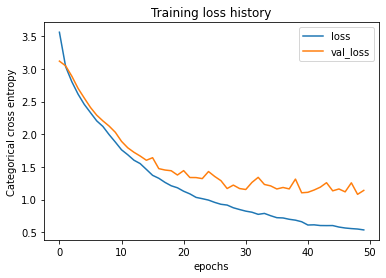

In [12]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

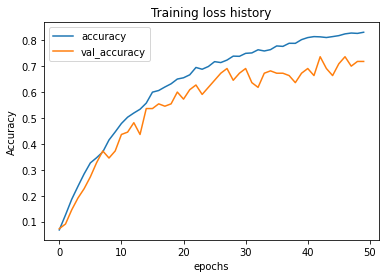

In [13]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [14]:
#sanity check, evaluate on the validation set
L1_model2.evaluate(validation_ds)

4/4 [==============================] - 1s 9ms/step - loss: 1.1398 - accuracy: 0.7182


[1.1397626399993896, 0.7181817889213562]

In [15]:
#moment of truth
L1_model2.evaluate(test_ds)

4/4 [==============================] - 6s 10ms/step - loss: 0.9831 - accuracy: 0.7455


[0.9831064343452454, 0.7454545497894287]

In [16]:
L1_model2.save('L1AugmentationModel.h5')

In [17]:
valid_generator = ImageDataGenerator()
img_width, img_height = 256, 256
valid_data_generator = valid_generator.flow_from_directory(
     '/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/valid',
     target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)

valid_steps_per_epoch = np.math.ceil(valid_data_generator.samples / valid_data_generator.batch_size)
predictions = L1_model2.predict(valid_data_generator, steps=valid_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 110 images belonging to 22 classes.
4/4 [==============================] - 31s 7s/step


In [47]:
true_classes = valid_data_generator.classes
class_labels = list(valid_data_generator.class_indices.keys())  

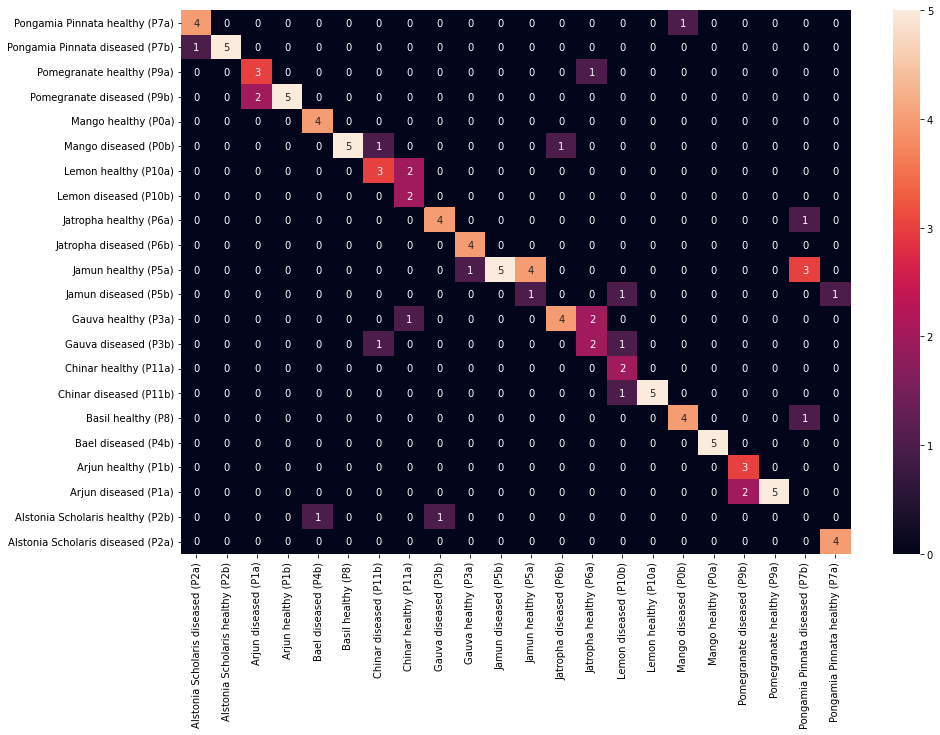

In [62]:
x_labels = class_labels
y_labels = class_labels[::-1]
fig , ax = plt.subplots(figsize=(15, 10))
ax= plt.subplot()
fig = sns.heatmap(confusion_matrix(predicted_classes, true_classes)
                  ,annot = True, fmt='g', ax=ax, xticklabels = x_labels, yticklabels= y_labels)



In [49]:
#metrics report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                                   precision    recall  f1-score   support

Alstonia Scholaris diseased (P2a)       0.80      0.80      0.80         5
 Alstonia Scholaris healthy (P2b)       0.83      1.00      0.91         5
             Arjun diseased (P1a)       0.75      0.60      0.67         5
              Arjun healthy (P1b)       0.71      1.00      0.83         5
              Bael diseased (P4b)       1.00      0.80      0.89         5
               Basil healthy (P8)       0.71      1.00      0.83         5
           Chinar diseased (P11b)       0.60      0.60      0.60         5
            Chinar healthy (P11a)       1.00      0.40      0.57         5
             Gauva diseased (P3b)       0.80      0.80      0.80         5
              Gauva healthy (P3a)       1.00      0.80      0.89         5
             Jamun diseased (P5b)       0.38      1.00      0.56         5
              Jamun healthy (P5a)       0.33      0.20      0.25         5
          Jatropha disea

In [ ]:
L1_model2.save('BestL1Model.h5')

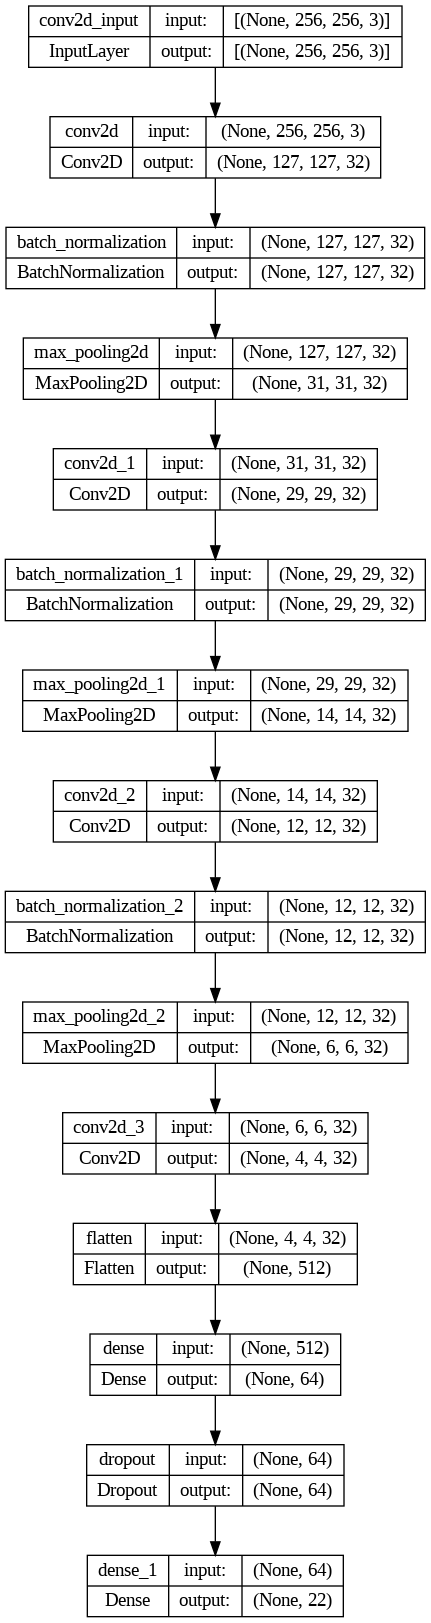

In [72]:
#plot the model Architecture
plot_model(L1_model2, show_shapes=True, show_layer_names=True)

Look at the misclassified leaves

In [ ]:
plt.figure(figsize=(10, 10))
class_names = test_data.class_names
for images, labels in test_data.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/train/Pongamia Pinnata diseased (P7b)/0019_0015.JPG'
Load_image = tf.keras.preprocessing.image.load_img(path)
Load_image

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/train/Jamun healthy (P5a)/0005_0011.JPG'
Load_image = tf.keras.preprocessing.image.load_img(path)
Load_image

#L2 (Ridge Regression) regularizer with Augmentation

In [ ]:
#setup a regularizer 
reg = L2(3e-5)

In [ ]:
#since I only have 4K data points for 22 classifications, using augments to create more data
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

In [ ]:
#making a learning rate schedule to decay the learning rate 
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=50,
    decay_rate=0.9)

In [ ]:
L2_model = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
L2_model.add(Conv2D(filters=32,
                        kernel_size=(3, 3), strides = (2,2),
                        activation='relu',
                        input_shape=(256, 256, 3),
                        kernel_regularizer = reg))

#rescale the images 
tf.keras.layers.Rescaling(1./255)
# max pool in 2x2 window
L2_model.add(BatchNormalization())
L2_model.add(MaxPooling2D(pool_size=(4, 4)))
data_augmentation
L2_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))

L2_model.add(BatchNormalization())
L2_model.add(MaxPooling2D((2, 2)))
data_augmentation
L2_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))

# transition to dense fully-connected part of network
L2_model.add(Flatten())
L2_model.add(Dense(64, activation='relu'))
L2_model.add(Dropout(0.3)) 
L2_model.add(Dense(22, activation='softmax'))

In [ ]:
opt = Adam(learning_rate = lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-05)
L2_model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
history_cnn = L2_model.fit(train_ds, epochs= 50, validation_data= validation_ds)

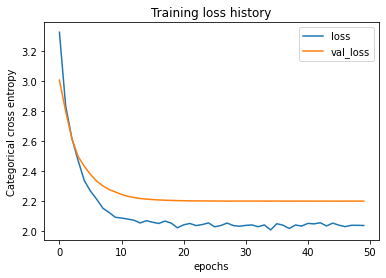

In [ ]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

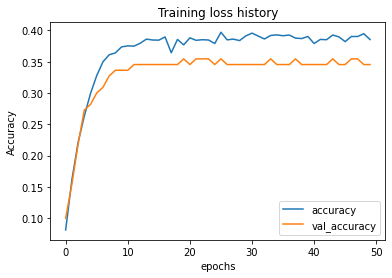

In [ ]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [ ]:
L2_model.save('L2Model.h5')

#Transfer learning 

In [89]:
from tensorflow.keras.applications import VGG16, VGG19

In [90]:
#remove the top layer 
base_vgg_model = VGG16(include_top=False, weights = 'imagenet')
for layers in base_vgg_model.layers:
  layers.trainable = False

base_vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Resizing, RandomFlip, RandomRotation
from tensorflow.keras.layers import GlobalAveragePooling2D

In [94]:
# data augmenter and resize
data_augmentation_vgg = tf.keras.Sequential([
  Resizing(224, 224),
])

# specialized vgg16 preprocesser
vgg_processor = tf.keras.applications.vgg16.preprocess_input 

In [95]:
def my_little_model():
  input = Input(shape = (256,256, 3))
  x = data_augmentation_vgg(input)
  x = vgg_processor(x)
  x = base_vgg_model(x)
  x = Conv2D(22, 1, padding = 'same', activation = 'relu')(x)
  x = GlobalAveragePooling2D()(x)
  output = Dense(22, activation = 'softmax')(x)

  my_first_vgg = Model(inputs = input, outputs = output)

  return my_first_vgg

In [ ]:
my_mod = my_little_model()
plot_model(my_mod, show_shapes=True, show_layer_names=True)

In [ ]:
my_mod.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history_cnn = my_mod.fit(train_ds, validation_data = validation_ds, epochs=30)

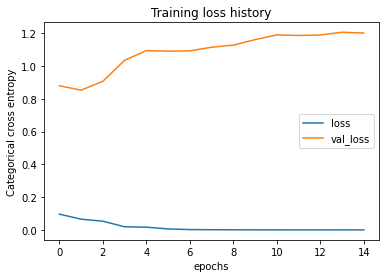

In [103]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

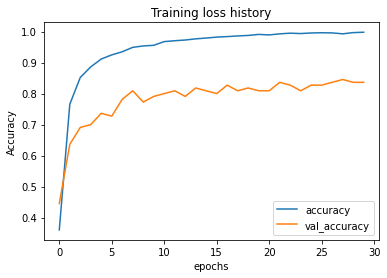

In [ ]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [ ]:
valid_generator = ImageDataGenerator()
img_width, img_height = 256, 256
valid_data_generator = valid_generator.flow_from_directory(
     '/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/valid',
     target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)
valid_steps_per_epoch = np.math.ceil(valid_data_generator.samples / valid_data_generator.batch_size)

predictions = my_mod.predict(valid_data_generator, steps=valid_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 110 images belonging to 22 classes.
4/4 [==============================] - 37s 9s/step


In [ ]:
#create a confusion matrix
true_classes = valid_data_generator.classes
class_labels = list(valid_data_generator.class_indices.keys())

#confusion matrix labels
x_labels = class_labels
y_labels = class_labels[::-1]
plt.figure(figsize=(15, 10))
ax= plt.subplot()
sns.heatmap(confusion_matrix(predicted_classes, true_classes), 
            annot = True, fmt='g', ax=ax, xticklabels = x_labels, yticklabels= y_labels)

In [ ]:
#metrics report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
my_mod.save('Transfer_Model.h5')

#Fine Tuning

In [97]:
my_mod.layers[4].layers[-2].trainable = True
[layer.trainable for layer in my_mod.layers[4].layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False]

In [98]:
my_mod.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history_cnn = my_mod.fit(train_ds, validation_data = validation_ds, epochs=30)

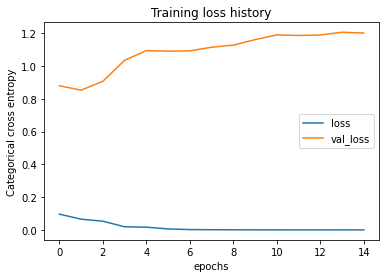

In [104]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

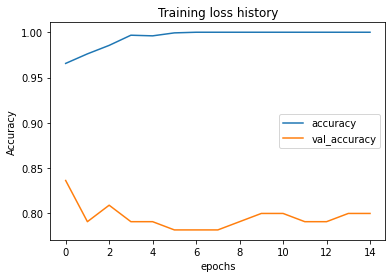

In [105]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [106]:
valid_generator = ImageDataGenerator()
img_width, img_height = 256, 256
valid_data_generator = valid_generator.flow_from_directory(
     '/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/valid',
     target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)
valid_steps_per_epoch = np.math.ceil(valid_data_generator.samples / valid_data_generator.batch_size)

predictions = my_mod.predict(valid_data_generator, steps=valid_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 110 images belonging to 22 classes.
4/4 [==============================] - 32s 8s/step


In [107]:
true_classes = valid_data_generator.classes
class_labels = list(valid_data_generator.class_indices.keys()) 

In [ ]:
x_labels = class_labels
y_labels = class_labels[::-1]
plt.figure(figsize=(15, 10))
ax= plt.subplot()
sns.heatmap(confusion_matrix(predicted_classes, true_classes), 
            annot = True, fmt='g', ax=ax, xticklabels = x_labels, yticklabels= y_labels)

In [ ]:
#metrics report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

#Regularize to help with overfitting 

In [120]:
#remove the top layer 
base_vgg_model = VGG16(include_top=False, weights = 'imagenet')
for layers in base_vgg_model.layers:
  layers.trainable = False

In [24]:
# data augmenter and resize
data_augmentation_vgg = tf.keras.Sequential([Resizing(224, 224),])

# specialized vgg16 preprocesser
vgg_processor = tf.keras.applications.vgg16.preprocess_input 

In [122]:
def my_middle_model():
  input = Input(shape = (256,256, 3))
  x = data_augmentation_vgg(input)
  x = vgg_processor(x)
  x = base_vgg_model(x)
  x = Conv2D(22, 1, padding = 'same', activation = 'relu', kernel_regularizer = reg)(x)
  x = GlobalAveragePooling2D()(x)
  output = Dense(22, activation = 'softmax')(x)

  my_first_vgg = Model(inputs = input, outputs = output)

  return my_first_vgg

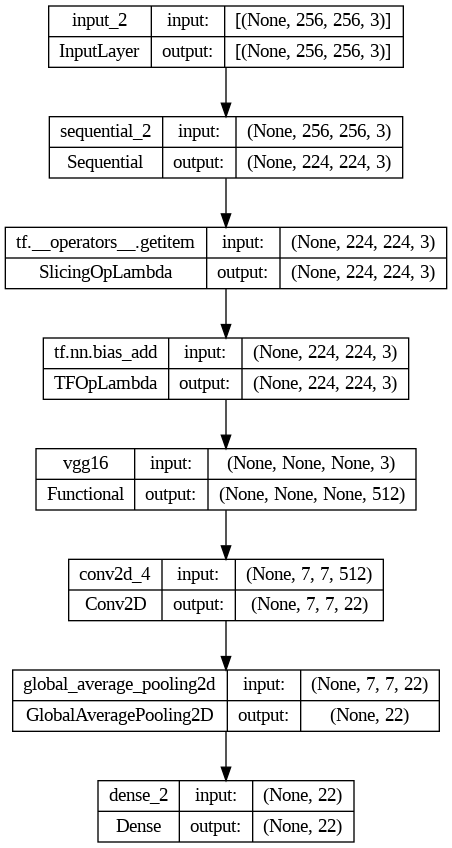

In [123]:
my_middle_model = my_middle_model()
plot_model(my_mod, show_shapes=True, show_layer_names=True)

In [ ]:
#use the weight from one of the later layers
my_middle_model.layers[4].layers[-2].trainable = True
[layer.trainable for layer in my_mod.layers[4].layers]

In [127]:
my_middle_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [128]:
history_cnn  = my_middle_model.fit(train_ds, validation_data = validation_ds, epochs=30)

Epoch 1/30
134/134 [==============================] - 49s 331ms/step - loss: 2.4984 - accuracy: 0.2433 - val_loss: 2.3527 - val_accuracy: 0.2455
Epoch 2/30
134/134 [==============================] - 47s 333ms/step - loss: 1.4801 - accuracy: 0.5559 - val_loss: 1.6328 - val_accuracy: 0.4455
Epoch 3/30
134/134 [==============================] - 47s 330ms/step - loss: 0.6368 - accuracy: 0.7993 - val_loss: 0.8560 - val_accuracy: 0.7273
Epoch 4/30
134/134 [==============================] - 48s 333ms/step - loss: 0.2567 - accuracy: 0.9228 - val_loss: 1.2354 - val_accuracy: 0.6727
Epoch 5/30
134/134 [==============================] - 47s 331ms/step - loss: 0.1813 - accuracy: 0.9455 - val_loss: 0.9935 - val_accuracy: 0.7364
Epoch 6/30
134/134 [==============================] - 47s 331ms/step - loss: 0.0865 - accuracy: 0.9750 - val_loss: 0.6575 - val_accuracy: 0.8182
Epoch 7/30
134/134 [==============================] - 47s 333ms/step - loss: 0.0587 - accuracy: 0.9869 - val_loss: 0.5958 - val_ac

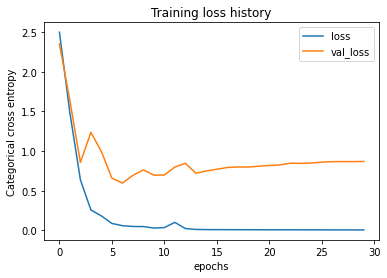

In [129]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

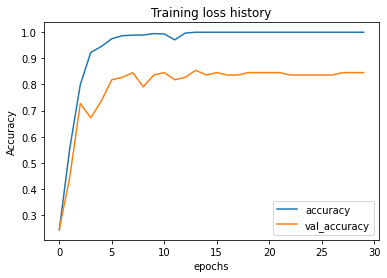

In [130]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [132]:
valid_generator = ImageDataGenerator()
img_width, img_height = 256, 256
valid_data_generator = valid_generator.flow_from_directory(
     '/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/valid',
     target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)
valid_steps_per_epoch = np.math.ceil(valid_data_generator.samples / valid_data_generator.batch_size)

predictions = my_middle_model.predict(valid_data_generator, steps=valid_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 110 images belonging to 22 classes.
4/4 [==============================] - 32s 7s/step


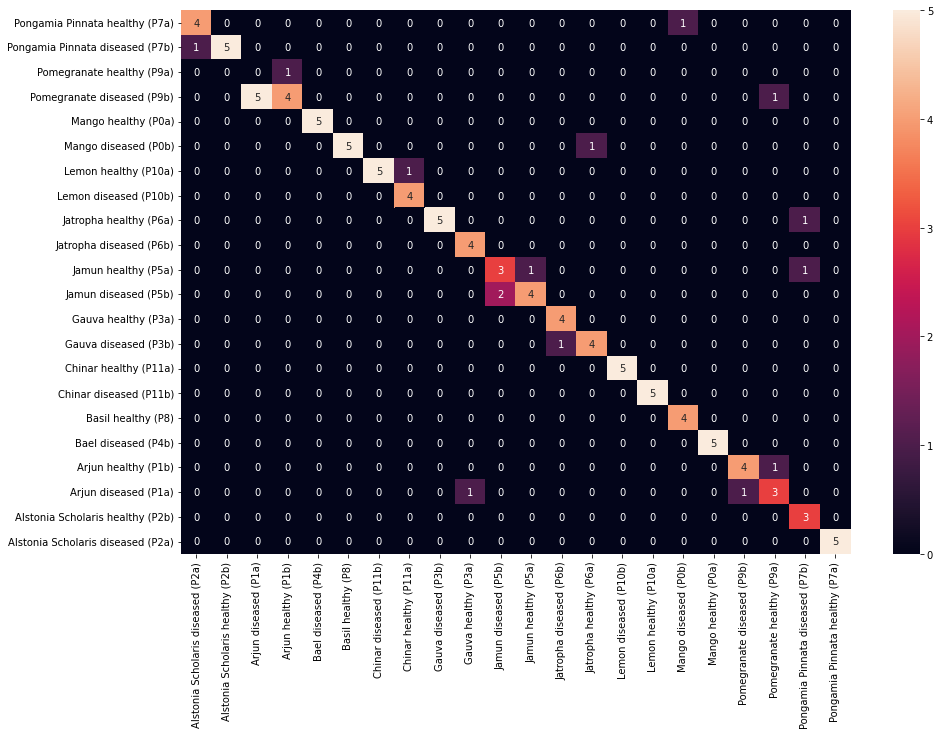

In [134]:
true_classes = valid_data_generator.classes
class_labels = list(valid_data_generator.class_indices.keys())

x_labels = class_labels
y_labels = class_labels[::-1]
plt.figure(figsize=(15, 10))
ax= plt.subplot()
sns.heatmap(confusion_matrix(predicted_classes, true_classes), 
            annot = True, fmt='g', ax=ax, xticklabels = x_labels, yticklabels= y_labels)

In [135]:
#metrics report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                                   precision    recall  f1-score   support

Alstonia Scholaris diseased (P2a)       0.80      0.80      0.80         5
 Alstonia Scholaris healthy (P2b)       0.83      1.00      0.91         5
             Arjun diseased (P1a)       0.00      0.00      0.00         5
              Arjun healthy (P1b)       0.40      0.80      0.53         5
              Bael diseased (P4b)       1.00      1.00      1.00         5
               Basil healthy (P8)       0.83      1.00      0.91         5
           Chinar diseased (P11b)       0.83      1.00      0.91         5
            Chinar healthy (P11a)       1.00      0.80      0.89         5
             Gauva diseased (P3b)       0.83      1.00      0.91         5
              Gauva healthy (P3a)       1.00      0.80      0.89         5
             Jamun diseased (P5b)       0.60      0.60      0.60         5
              Jamun healthy (P5a)       0.67      0.80      0.73         5
          Jatropha disea

In [137]:
#sanity check, evaluate on the validation set
my_middle_model.evaluate(validation_ds)

#moment of truth
my_middle_model.evaluate(test_ds)

4/4 [==============================] - 1s 22ms/step - loss: 0.9515 - accuracy: 0.8727


[0.9514584541320801, 0.8727272748947144]

#Resnet 50

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [33]:
#add reguarlizer to reduce overfitting 
reg = L1(3e-5)

In [34]:
#remove the top layer 
base_resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                            weights = 'imagenet')
for layers in base_resnet_model.layers:
  layers.trainable = False

In [35]:
# data augmenter and resize
data_augmentation_resnet50 = tf.keras.Sequential([
  Resizing(224, 224),])

# specialized resnet50 preprocesser
resent_processor = tf.keras.applications.resnet50.preprocess_input 


In [36]:
def my_resnet_model():
  input = Input(shape = (256,256, 3))
  x = data_augmentation_resnet50(input)
  x = resent_processor(x)
  x = base_resnet_model(x)
  x = Conv2D(22, 1, padding = 'same', activation = 'relu', kernel_regularizer = reg)(x)
  x = GlobalAveragePooling2D()(x)
  output = Dense(22, activation = 'softmax')(x)

  my_first_resnet = Model(inputs = input, outputs = output)

  return my_first_resnet

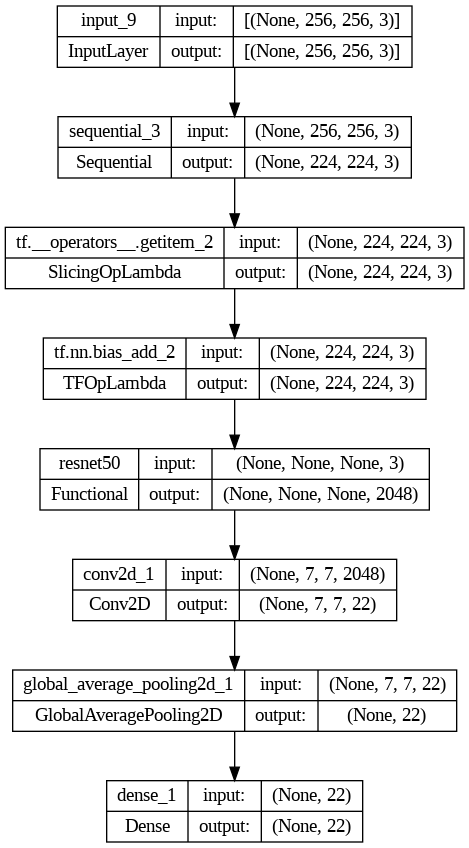

In [38]:
first_resnet_model = my_resnet_model()
plot_model(first_resnet_model, show_shapes=True, show_layer_names=True)

In [ ]:
##use the weight from one of the later layers
first_resnet_model.layers[4].layers[-2].trainable = True
[layer.trainable for layer in first_resnet_model.layers[4].layers]

In [41]:
first_resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [43]:
history_cnn  = first_resnet_model.fit(train_ds, validation_data = validation_ds, epochs=15)

Epoch 1/15
134/134 [==============================] - 48s 337ms/step - loss: 0.4769 - accuracy: 0.8800 - val_loss: 0.5558 - val_accuracy: 0.8455
Epoch 2/15
134/134 [==============================] - 48s 334ms/step - loss: 0.3072 - accuracy: 0.9235 - val_loss: 0.5584 - val_accuracy: 0.8000
Epoch 3/15
134/134 [==============================] - 48s 338ms/step - loss: 0.2395 - accuracy: 0.9460 - val_loss: 0.5687 - val_accuracy: 0.8364
Epoch 4/15
134/134 [==============================] - 48s 337ms/step - loss: 0.2057 - accuracy: 0.9593 - val_loss: 0.4580 - val_accuracy: 0.8727
Epoch 5/15
134/134 [==============================] - 48s 340ms/step - loss: 0.1761 - accuracy: 0.9633 - val_loss: 0.4323 - val_accuracy: 0.8545
Epoch 6/15
134/134 [==============================] - 48s 335ms/step - loss: 0.1515 - accuracy: 0.9747 - val_loss: 0.4313 - val_accuracy: 0.8909
Epoch 7/15
134/134 [==============================] - 48s 338ms/step - loss: 0.1383 - accuracy: 0.9799 - val_loss: 0.4219 - val_ac

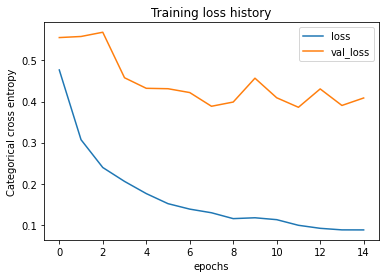

In [44]:
train_cnn_history = pd.DataFrame(history_cnn.history)
train_cnn_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_cnn_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

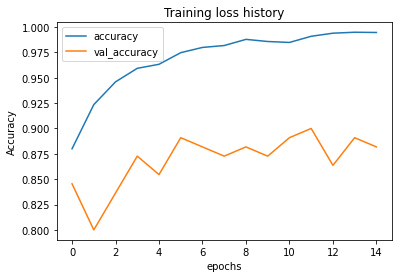

In [45]:
col_list = ['accuracy', 'val_accuracy']
train_cnn_history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

In [46]:
valid_generator = ImageDataGenerator()
img_width, img_height = 256, 256
valid_data_generator = valid_generator.flow_from_directory(
     '/content/drive/MyDrive/Colab Notebooks/Plant_Leaf_Classitication/Data/Plants_2/valid',
     target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)
valid_steps_per_epoch = np.math.ceil(valid_data_generator.samples / valid_data_generator.batch_size)

predictions = first_resnet_model.predict(valid_data_generator, steps=valid_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 110 images belonging to 22 classes.
4/4 [==============================] - 33s 7s/step


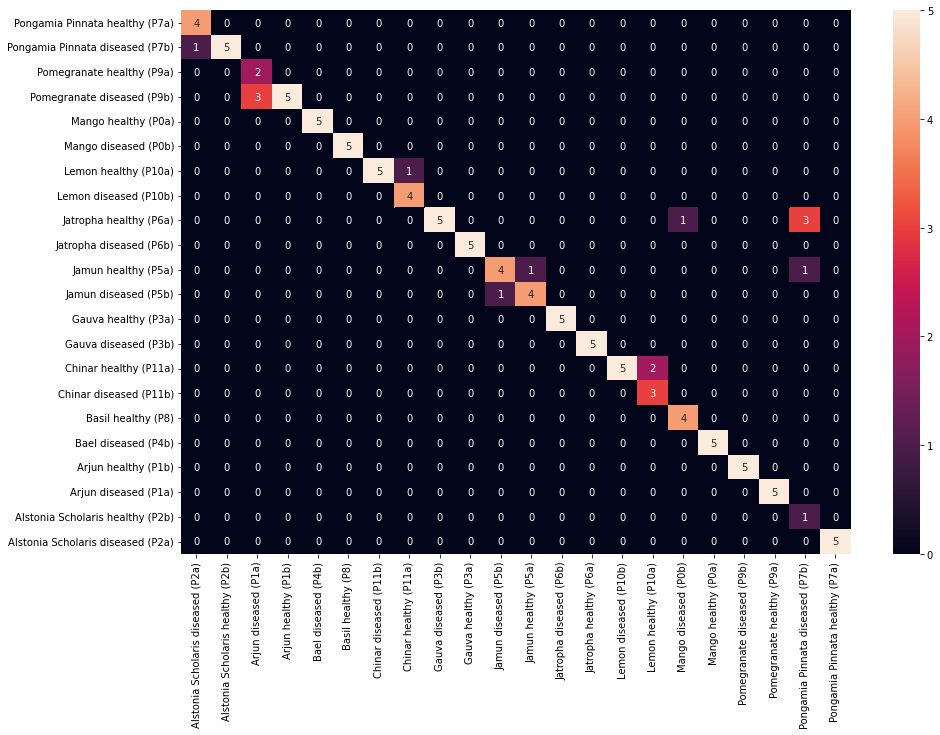

In [47]:
true_classes = valid_data_generator.classes
class_labels = list(valid_data_generator.class_indices.keys())

x_labels = class_labels
y_labels = class_labels[::-1]
plt.figure(figsize=(15, 10))
ax= plt.subplot()
sns.heatmap(confusion_matrix(predicted_classes, true_classes), 
            annot = True, fmt='g', ax=ax, xticklabels = x_labels, yticklabels= y_labels)

In [48]:
#metrics report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                                   precision    recall  f1-score   support

Alstonia Scholaris diseased (P2a)       1.00      0.80      0.89         5
 Alstonia Scholaris healthy (P2b)       0.83      1.00      0.91         5
             Arjun diseased (P1a)       1.00      0.40      0.57         5
              Arjun healthy (P1b)       0.62      1.00      0.77         5
              Bael diseased (P4b)       1.00      1.00      1.00         5
               Basil healthy (P8)       1.00      1.00      1.00         5
           Chinar diseased (P11b)       0.83      1.00      0.91         5
            Chinar healthy (P11a)       1.00      0.80      0.89         5
             Gauva diseased (P3b)       0.56      1.00      0.71         5
              Gauva healthy (P3a)       1.00      1.00      1.00         5
             Jamun diseased (P5b)       0.67      0.80      0.73         5
              Jamun healthy (P5a)       0.80      0.80      0.80         5
          Jatropha disea

In [49]:
#sanity check, evaluate on the validation set
first_resnet_model.evaluate(validation_ds)

#moment of truth
first_resnet_model.evaluate(test_ds)

4/4 [==============================] - 5s 25ms/step - loss: 0.3159 - accuracy: 0.9364


[0.3159283399581909, 0.9363636374473572]